<a href="https://colab.research.google.com/github/constructor-s/aps1080_winter_2021/blob/main/E2/E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise II: Cart Pole preliminaries and Monte Carlo

Open Files/A2_... and study it in Colab by running it.

Observe how all the facets of a reinforcement learning coupled machine/environment system are present.

The notebook includes some code to show how the behaviour of the agent can be rendered, using a random policy that exploits the .sample() method.

## A2_CartPoleWithRendering.ipynb

In [6]:
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [7]:
# !pip install gym pyvirtualdisplay > /dev/null 2>&1

In [8]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [9]:
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(400, 300))
# display.start()

In [10]:
env = gym.make("CartPole-v0")
env.reset()
# prev_screen = env.render(mode='rgb_array')
# plt.imshow(prev_screen)

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
#   screen = env.render(mode='rgb_array')
  
#   plt.imshow(screen)
#   ipythondisplay.clear_output(wait=True)
#   ipythondisplay.display(plt.gcf())

  if done:
    break
    
# ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

step i 0 action= 0
obs= [-0.01269733 -0.16805774  0.01115469  0.34068777] reward= 1.0 done= False info= {}
step i 1 action= 1
obs= [-0.01605849  0.02690374  0.01796844  0.05154316] reward= 1.0 done= False info= {}
step i 2 action= 1
obs= [-0.01552041  0.2217635   0.01899931 -0.23541685] reward= 1.0 done= False info= {}
step i 3 action= 1
obs= [-0.01108514  0.41660892  0.01429097 -0.52204677] reward= 1.0 done= False info= {}
step i 4 action= 1
obs= [-0.00275296  0.61152683  0.00385003 -0.81019239] reward= 1.0 done= False info= {}
step i 5 action= 0
obs= [ 0.00947757  0.41635234 -0.01235381 -0.51630092] reward= 1.0 done= False info= {}
step i 6 action= 1
obs= [ 0.01780462  0.61164605 -0.02267983 -0.81285106] reward= 1.0 done= False info= {}
step i 7 action= 1
obs= [ 0.03003754  0.80707118 -0.03893685 -1.11258066] reward= 1.0 done= False info= {}
step i 8 action= 1
obs= [ 0.04617896  1.00268228 -0.06118847 -1.41721946] reward= 1.0 done= False info= {}
step i 9 action= 1
obs= [ 0.06623261 

## Exercise 1:

> Can you design a dynamic programming based policy for the agent as in assignment 1? If so, design it and demonstrate that it solves the cart pole problem.


No. Designing a dynamic programming based policy requires explicit knowledge of the environment transition probabilities $p(s',r|s,a)$. For the `CartPole` environment, the behaviors are dicated by laws of physics that can be easily simulated but is extremely difficult to translate into the form of $p(s',r|s,a)$.

## Exercise 2:

> Can you design a Monte Carlo based policy for the agent? What ingredients do you require? Explain the design flow, and execute it. Show that it works, or indicate why you can't proceed.

Yes. To design a Monte Carlo based policy we require the ability to generate and record episodes of experience in this environment. Below is an implementation of *on-policy first-visit MC control for $\epsilon$-soft policies* where the agent has learned to maintain balance for more than 100 iterations. One challenge is that the state observation from the environment is expressed as four continous variables (0 Cart Position, 1 Cart Velocity, 2 Pole Angle, 3 Pole Angular Velocity); for simplicity we will for now discretize this into a finite number of states.

In [54]:
from collections import defaultdict

"""
Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf
"""

def obs2state(obs):
    """
    Discretize observations to states
    """
    digitized = [np.digitize(obs[i], bins) for i, bins in enumerate([
        np.linspace(-4.8, +4.8, 9)[1:-1],
        np.linspace(-0.6, +0.6, 7),
        np.linspace(-0.418, +0.418, 9)[1:-1],
        np.linspace(-0.6, +0.6, 7),
        ])]
    return ((obs > 0) * 8**np.arange(len(obs))).sum()
obs2state.S = 8**len(obs)

def init_random_policy(eps, S, A, rng):
    pi_random_init = rng.random([S, A])
    pi_random_mask = np.zeros_like(pi_random_init, dtype=np.float)
    pi_random_mask[np.arange(S), np.argmax(pi_random_init, axis=1)] = True
    pi = pi_random_mask * (1 - eps) + eps / A
    return pi

In [59]:
#%% On-policy first-visit MC control
eps=0.05
gamma=0.99
env=env
rng=np.random.RandomState(0)
# Initialize
A = env.action_space.n
actions = np.arange(A)
S = obs2state.S
states = np.arange(S)

# pi <- an arbitrary epsilon soft policy
pi = init_random_policy(eps, S, A, rng)
# Arbitrary Q initialization
Q = rng.random([S, A])
# Empty initialization for returns
Returns = defaultdict(lambda : defaultdict(list))

iterations_lasted = []
# Repeat forever for each episode
for episode in range(1000):
    # Generate an episode following pi
    done = False
    obs = env.reset()
    R = []
    SA = [] # S, A pairs history
    for i in range(50000):
        state = obs2state(obs)
        action = rng.choice(np.arange(A), p=pi[state])
        SA.append((state, action))

        obs, reward, done, info = env.step(action)
        R.append(reward)

        if done:
            break
    
    iterations_lasted.append(i)

    G = 0
    # Loop backward for each step of episode
    # i is where the loop above finished, i.e. T
    for t in range(i, -1, -1):
        G = gamma * G + R[t]
        St, At = SA[t]
        if not (St, At) in SA[0:t]:
            Returns[St][At].append(G)
            Q[St, At] = np.mean(Returns[St][At])
            A_star = np.argmax(Q[St])
            for a in range(A):
                if a == A_star:
                    pi[St, a] = 1 - eps + eps / A
                else:
                    pi[St, a] = eps / A
    print(".", end="")


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[Text(0, 0.5, 'Iterations lasted'), Text(0.5, 0, 'Episode number')]

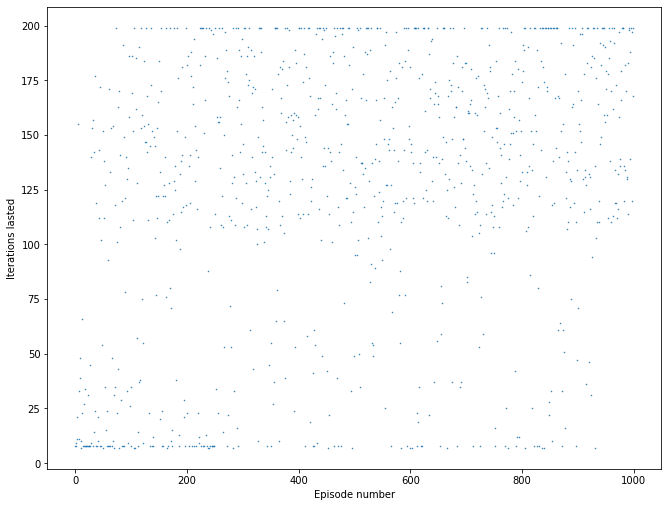

In [72]:
fig, ax = plt.subplots(figsize=(11, 8.5))
ax.plot(iterations_lasted, '.', markersize=1)
ax.set(xlabel="Episode number", ylabel="Iterations lasted")

In [74]:
# Convert epsilon-soft policy to a greedy policy
pi_greedy = np.zeros_like(pi, dtype=np.float)
pi_greedy[np.arange(S), np.argmax(pi, axis=1)] = 1

# Test
done = False
obs = env.reset()
for i in range(50000):
    state = obs2state(obs)
    action = rng.choice(np.arange(A), p=pi[state])

    print("step i",i,"action=",action)
    obs, reward, done, info = env.step(action)
    print("obs=",obs,"reward=",reward,"done=",done,"info=",info)

    if done:
        break

step i 0 action= 1
obs= [-0.03863433  0.19923228  0.01313335 -0.26377668] reward= 1.0 done= False info= {}
step i 1 action= 0
obs= [-0.03464969  0.00392536  0.00785782  0.03301954] reward= 1.0 done= False info= {}
step i 2 action= 1
obs= [-0.03457118  0.19893375  0.00851821 -0.25717384] reward= 1.0 done= False info= {}
step i 3 action= 0
obs= [-0.0305925   0.00369123  0.00337473  0.03818364] reward= 1.0 done= False info= {}
step i 4 action= 1
obs= [-0.03051868  0.19876462  0.00413841 -0.25343261] reward= 1.0 done= False info= {}
step i 5 action= 0
obs= [-0.02654339  0.00358383 -0.00093025  0.04055276] reward= 1.0 done= False info= {}
step i 6 action= 0
obs= [-2.64717106e-02 -1.91524774e-01 -1.19190111e-04  3.32942043e-01] reward= 1.0 done= False info= {}
step i 7 action= 0
obs= [-0.03030221 -0.38664503  0.00653965  0.62558738] reward= 1.0 done= False info= {}
step i 8 action= 1
obs= [-0.03803511 -0.19161498  0.0190514   0.3349712 ] reward= 1.0 done= False info= {}
step i 9 action= 1
ob